In [1]:
import numpy as np
from numpy import inf
from numpy import nan

import math
from scipy.optimize import differential_evolution
from scipy.stats import entropy

import time

import multiprocessing as mp
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
%matplotlib inline 


### parameters

In [2]:
popSize = 500 # population size
n =5 # group size for individual interactions

mu = 0.1 # mutation rate
sigma=0.005 #mutation size



In [3]:
b2 = -6 # quadratic benefit coefficient for task X
beta =3 # slope of benefit for task Y (eg. brood care)
alpha = 2 # selection intensity in social learning

## Total Benefit Accrue to Individuals Inside a Game

In [4]:
def benefit(G,b1,w):
    
    G=np.array(G)
    X = G[:,0]
    Y = G[:,1]
    total_engagement_in_task_X = np.sum(X)
    total_engagement_in_task_Y = np.sum(Y)
    
    B_X = (b2*(total_engagement_in_task_X**2) + (b1*total_engagement_in_task_X))
    B_Y = (1)/(1+ ((1-w*total_engagement_in_task_Y)/(w*total_engagement_in_task_Y))**beta)
    B_total = (1/n)*(B_X)* B_Y
    return(B_total)

### Cost of Task X

In [5]:
def cost_X(player,b1,w):

     return(-1*(player[0]**2) + 2*(player[0]))

### Cost of Task Y

In [6]:
def cost_Y(player,b1,w):
    
    return(-1*(player[1]**2) + 2*(player[1]))

## Total Cost For an Individual

In [7]:
def cost(player,b1,w):
    return (cost_X(player,b1,w) + cost_Y(player,b1,w))

## Payoff Array of the Individuals Inside a Game

In [8]:
def payoffGame(G,b1,w):

    B = np.array(benefit(G,b1,w))
    C = np.array(list(map(cost,G,[b1]*len(G),[w]*len(G))))
    return (B-C)

## Mutations

In [9]:
def mutate_xy(player):

    
    a = np.random.uniform(0,1) 
    b = np.random.uniform(0,1) 
    if a < mu and b < mu:
        return(both_traits_mutation(player[0],player[1]))
    elif a < mu and b > mu:
        return(only_trait1_mutation(player[0],player[1]))
    elif a > mu and b < mu:
        return(only_trait2_mutation(player[0],player[1]))
    else:
        return(player[0],player[1])

In [10]:
def only_trait1_mutation(trait1,trait2):
    flag =0
    while flag==0:
        temp = np.clip(np.random.normal(trait1,sigma),0,1)
        if temp + trait2 <= 1:
            flag = 1
            return(temp,trait2)
        else:
            continue

In [11]:
def only_trait2_mutation(trait1,trait2):
    flag =0
    while flag==0:
        temp = np.clip(np.random.normal(trait2,sigma),0,1)
        if temp + trait1 <= 1:
            flag = 1
            return(trait1,temp)
        else:
            continue

In [12]:
def both_traits_mutation(trait1,trait2):
    flag =0
    while flag==0:
        temp1 = np.clip(np.random.normal(trait1,sigma),0,1)
        temp2 = np.clip(np.random.normal(trait2,sigma),0,1)
        if temp1 + temp2 <= 1:
            flag = 1
            return(temp1,temp2)
        else:
            continue

## One Round Gameplay in Population

In [21]:
def oneRound(b1,w,alpha):
    global population
    global X
    global Y
    global average_allPayoffs
        
    
    np.random.shuffle(population)
    allGames = np.split(population,popSize/n)
    allPayoff = np.array(list(map(payoffGame, allGames,[b1]*len(allGames),[w]*len(allGames))))
    allPayoffs = allPayoff.flatten()
    average_allPayoffs = sum(allPayoffs)/popSize
    allPayoffs = np.exp(np.multiply(allPayoffs,alpha))
    indexes = np.random.choice(np.arange(0,popSize),popSize,replace=True,p=allPayoffs/np.sum(allPayoffs))
    
    parents = np.array([population[i] for i in indexes])
    a=np.where((abs(population[:,0]-parents[:,0])< 0.2) & (abs(population[:,1]-parents[:,1])< 0.2))
    a=np.ndarray.tolist(a[0])
    population=np.ndarray.tolist(population)
    parents=np.ndarray.tolist(parents)
    for i in a:
        population[i]=np.copy(parents[i])
    population=np.array(population)
    parents=np.array(parents)

    popTemp = np.array(list(map(mutate_xy,population)))
    X = popTemp[:,0]
    Y = popTemp[:,1]
    population[:,0]= X
    population[:,1]= Y

## Iterative Game Playing

In [22]:
def play(startTrait, tEnd, plotInterval,b1,w,alpha):
    global popSize
    global population
    global X
    global Y
    global average_allPayoffs
    global all_x_traits
    global all_y_traits
    all_x_traits=[]
    all_y_traits=[]
    population = np.array(startTrait*popSize)
    for t in range(1,tEnd+1):
        if (t%plotInterval == 0):
            all_x_traits.append(X)
            all_y_traits.append(Y)
        oneRound(b1,w,alpha)

## Traits Dynamic Plotting

In [23]:
def plotEvolutions(tEnd, plotInterval,b1,w,alpha):
    global popSize
    global all_x_traits
    global all_y_traits
    
    t = np.array([ np.full(popSize,i*plotInterval) for i in range(1,1+tEnd//plotInterval) ]).flatten()
    x = np.array(all_x_traits).flatten()
    y=np.array(all_y_traits).flatten()
   

    
    plt.rcParams["font.family"] = "sans-serif"
    font = FontProperties()
    fig, ax = plt.subplots()
    ax.plot(t, x, '.', color='mediumvioletred',markersize=0.1,label='x')
    ax.plot(t, y, '.',color='seagreen', markersize=0.1,label='y')
    ax.plot(t, 1-x-y, '.',color='midnightblue',markersize=0.1, label='z')
    
    legend = ax.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=120, shadow=True,prop={'size':14,'weight':'bold'})
    ax.set_xlabel('time', fontsize=16,fontweight="bold")
    ax.set_ylabel('trait values', fontsize=16,fontweight="bold")
    
    fontproperties = {'weight' : 'bold', 'size' : 16}
    ax.set_xticklabels(ax.get_xticks(), fontproperties)
    ax.set_yticklabels(ax.get_yticks(), fontproperties)
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.margins(0)

    plt.ylim((0,1))
    plt.grid(False)    
    plt.show()
    
    
    
  ##############################################################################################################    
    fig, ax = plt.subplots()
    ax.plot(t, x, '.', color='mediumvioletred', markersize=0.05,label='x')
    legend = ax.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
    ax.set_xlabel('time', fontsize=16,fontweight="bold")
    ax.set_ylabel('x', fontsize=16,fontweight="bold")
    
    fontproperties = {'weight' : 'bold', 'size' : 16}
    ax.set_xticklabels(ax.get_xticks(), fontproperties)
    ax.set_yticklabels(ax.get_yticks(), fontproperties)
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.margins(0)

    plt.ylim((0,1))
    plt.grid(False)
    plt.show()
    
    
  ##############################################################################################################    
    fig, ax = plt.subplots()
    ax.plot(t, y, '.',color='seagreen', markersize=0.05,label='y')
    legend = ax.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
    ax.set_xlabel('time', fontsize=16,fontweight="bold")
    ax.set_ylabel('y', fontsize=16,fontweight="bold")
    
    fontproperties = {'weight' : 'bold', 'size' : 16}
    ax.set_xticklabels(ax.get_xticks(), fontproperties)
    ax.set_yticklabels(ax.get_yticks(), fontproperties)
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.margins(0)

    plt.ylim((0,1))
    plt.grid(False)    
    plt.show()
    
    
 ##############################################################################################################    
    fig, ax = plt.subplots()
    ax.plot(t, 1-x-y, '.',color='midnightblue',markersize=0.05, label='z')
    legend = ax.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
    ax.set_xlabel('time', fontsize=16,fontweight="bold")
    ax.set_ylabel('z', fontsize=16,fontweight="bold")
    
    fontproperties = {'weight' : 'bold', 'size' : 16}
    ax.set_xticklabels(ax.get_xticks(), fontproperties)
    ax.set_yticklabels(ax.get_yticks(), fontproperties)
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.margins(0)

    plt.ylim((0,1))
    plt.grid(False) 
    plt.show()


## Run function

In [24]:
def run(startTrait, tEnd, plotInterval,b1,w,alpha):
    start = time.time() # should use process_time but only available in Python 3.3 and up 
    play(startTrait, tEnd, plotInterval,b1,w,alpha)
    end = time.time() 
    print(end - start)
    plotEvolutions(tEnd, plotInterval,b1,w,alpha)
    return(sum(population[:,0]))

## Testing

/Users/mkha0093/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


1017.7273290157318


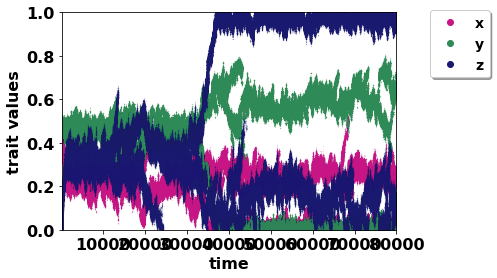

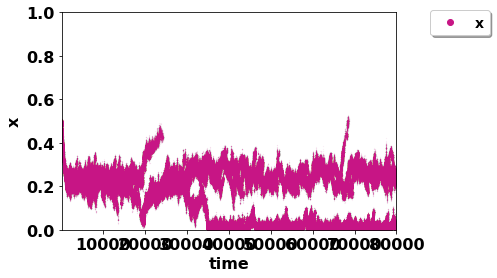

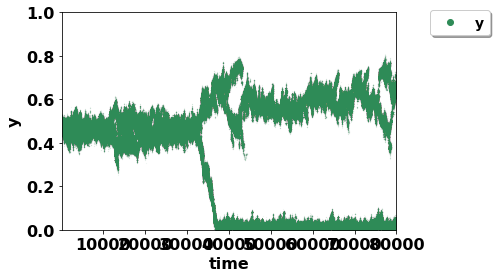

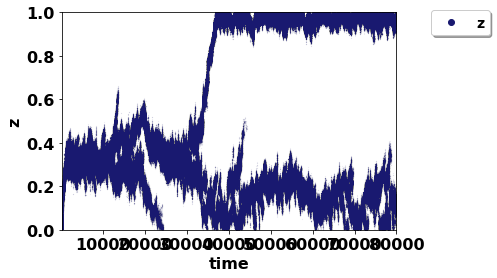

58.52826622414576

In [26]:
x=0.5
y=0.5
run([[x,y]],80000,10,22,0.3,1.5)

## Price of Anarchy (Efficiency Analysis)

In [1213]:
def fobj(X,b1,w):
    G=[]
    for i in range(0,len(X),2):
        G.append([X[i],X[i+1]])
    out= -payoffGame(G,b1,w)
    return(sum(out))
bounds=[(0,1)]*10;

In [1214]:
def run(startTrait, tEnd, plotInterval,b1,w,alpha):
    start = time.time()
    play(startTrait, tEnd, plotInterval,b1,w,alpha)
    end = time.time() 
    return(average_allPayoffs)

In [1215]:
x = 0.5
y = 0.5
b_range = np.linspace(12,30,120);
w_range = np.linspace(0.1,0.5,100);

## Optimal workforce allocation, using stochastic global optimisation meta-heuristic, Differential Evolution

In [1216]:
def efficieny(b1,w):
    pay = run([[x,y]],10000,200,b1,w,2)  
    result = differential_evolution(fobj, bounds,args=(b1,w),maxiter=10) 
    return(pay/(-result.fun/n)) 

### Paralel Computing

In [ ]:
args = [(x,y) for x in b_range for y in w_range]
pool = mp.Pool(mp.cpu_count())
matrix_efficiency = pool.starmap(efficieny, [args[i] for i in range(len(args))])
pool.close()

In [72]:
matrix_efficiency = np.reshape(matrix_efficiency,(120,100))

In [73]:
matrix_efficiency[matrix_efficiency == inf]=0
matrix_efficiency[matrix_efficiency <0]=0


In [34]:
import seaborn as sns; sns.set()
import matplotlib as mpl
from scipy.ndimage.filters import gaussian_filter

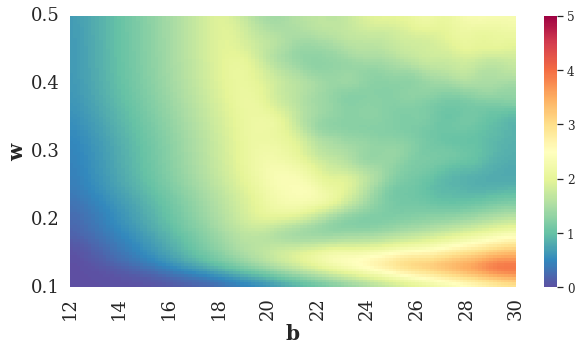

In [86]:
df3_smooth = gaussian_filter(np.transpose(matrix_efficiency), sigma=3)

fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax = sns.heatmap(df3_smooth ,cmap="Spectral_r",vmin=0, vmax=5, cbar_kws={"shrink": 1})


ax.invert_yaxis()
plt.xlabel("b")
plt.ylabel("r")


plt.rcParams["font.family"] = "serif"
font = FontProperties()
ax.set_xlabel('b', fontsize=20,fontweight="bold")
ax.set_ylabel('w', fontsize=20,fontweight="bold")
    
fontproperties = { 'size' : 18}
ax.set_xticks(np.linspace(0,120,10)) 
ax.set_xticklabels(['12','14','16','18','20','22','24','26','28','30'])
plt.xticks(fontsize= 18)

ax.set_yticks(np.linspace(0,100,5)) 
ax.set_yticklabels(['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8'])
plt.yticks(fontsize= 18)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)